In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=c1761cd20bf21cd9f59d9503d7c90e20446c9b681ef40149bc85a5b1cebed389
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
import os

import pandas as pd #used for data manipulation and analysis
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt #used for plotting
import seaborn as sns #used for plotting

from keras import callbacks, metrics, initializers, optimizers
from keras.models import Sequential #used for model building
from keras.layers import Dense #used for creating layers

from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score #import confusion matrix
from sklearn.metrics import roc_curve, precision_recall_curve #import ROC curve tools
from sklearn.model_selection import train_test_split #used for splitting data into training and testing sets
import joblib #used for saving and loading models

from eli5.sklearn.permutation_importance import get_score_importances

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

# Set Up

In [ ]:
mpl.rcParams['figure.figsize'] = (10,8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
np.random.seed(42)


# Data Preprocessing

## Load Data

In [ ]:
# function to load x
def load_x(data_path):
    df_x = pd.read_csv(data_path)
    # return the 7th and the second last column of the test data
    df_x = df_x.iloc[:,7:-1]
    # fill the missing data with the mean of the column
    df_x.loc[df_x['median_hs_income']=='**', 'median_hs_income'] = np.nan
    df_x['median_hs_income'] = df_x['median_hs_income'].astype(float)
    columns = [x for x in df_x.columns]
    impute = KNNImputer()
    df_x = impute.fit_transform(df_x)
    df_x = pd.DataFrame(df_x,columns=columns)
    return df_x


# function to load y
def load_y(data_path):
    df_y = pd.read_csv(data_path)
    df_y = df_y.iloc[:,-1]
    # fill the missing data with the mode of the column
    df_y = df_y.fillna(df_y.mode())
    return df_y



## Set Data Path

In [ ]:
# set the work directory to the project directory
path = '/content/drive/MyDrive/COM6101/project/RL.csv'
save_path = '/content/drive/MyDrive/COM6101/project/model-training-result'


In [ ]:
# load the data
x = load_x(path)
y = load_y(path)


## Describe the Data

In [ ]:
feature_name = x.columns

In [ ]:
x.describe().T


,count,mean,std,min,25%,50%,75%,max
number_of_nearby_restaurants,14067.0,35.157532,31.066114,0.000000,13.000000,27.000000,47.000000,176.000000
number_of_bus_stops,14067.0,0.687709,1.208915,0.000000,0.000000,0.000000,1.000000,8.000000
number_of_MTR_stations,14067.0,0.687069,1.696310,0.000000,0.000000,0.000000,0.000000,13.000000
number_of_schools,14067.0,1.124547,1.837447,0.000000,0.000000,0.000000,2.000000,17.000000
number_of_commercial_facilities,14067.0,2.316272,2.442425,0.000000,0.000000,2.000000,4.000000,20.000000
number_of_government_facilities,14067.0,1.215682,1.810589,0.000000,0.000000,1.000000,2.000000,23.000000
number_of_religious_facilities,14067.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
number_of_medical_facilities,14067.0,0.670363,1.329014,0.000000,0.000000,0.000000,1.000000,13.000000
number_of_hotel_facilities,14067.0,4.310230,19.731595,0.000000,0.000000,0.000000,2.000000,383.000000
mean_median_age,14067.0,44.228257,6.289422,32.786490,38.290918,40.003538,50.488131,66.700707


In [ ]:
neg, pos = np.bincount(y)
total = y.shape[0]
print(f"Total: {total}\n\
Positive: {pos}({(pos/total)*100:.4f}% of total)")


Total: 14067
Positive: 12363(87.8865% of total)


## Normalization

In [ ]:
scaler = StandardScaler()
x_scaler = scaler.fit_transform(x)


## Split the Data

In [ ]:
# split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_scaler, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2,random_state=42)


# Define the Model and Metrics

In [ ]:
METRICS =  [metrics.TruePositives(name='tp'),metrics.FalsePositives(name='fp'),
            metrics.TrueNegatives(name='tn'),metrics.FalseNegatives(name='fn'),
            metrics.BinaryAccuracy(name='accuracy'),metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),metrics.AUC(name='auc'),
            metrics.AUC(name='prc',curve='PR')]
# Define the neural network function
def ANN_model(neurons=34, learning_rate=0.05, momentum=0.1, weight_decay=0.0, nesterov=True, metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    # Define the model architecture
    model = Sequential()
    # Add the first hidden layer
    model.add(Dense(neurons, input_dim=x.shape[1], activation='relu', kernel_initializer='he_normal'))
    # Add the second hidden layer
    model.add(Dense(neurons, activation='relu', kernel_initializer='glorot_uniform'))
    # Add the third hidden layer
    model.add(Dense(neurons, activation='relu', kernel_initializer='he_normal'))
    # Add the output layer
    model.add(Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',bias_initializer=output_bias))
    # specify the optimizer
    optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov, weight_decay=weight_decay)
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    return model

# Baseline Model

In [ ]:
EPOCHS = 500
BATCH_SIZE = 8

callback = callbacks.EarlyStopping(monitor='val_auc',patience=5,mode='max',restore_best_weights=True)

## Model Summary

In [ ]:
model = ANN_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 34)                612       
                                                                 
 dense_1 (Dense)             (None, 34)                1190      
                                                                 
 dense_2 (Dense)             (None, 34)                1190      
                                                                 
 dense_3 (Dense)             (None, 1)                 35        
                                                                 
Total params: 3027 (11.82 KB)
Trainable params: 3027 (11.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Set the correct initial bias

In [ ]:
model.predict(x_train[:10])

1/1 [==============================] - 0s 321ms/step


array([[0.78211206],
       [0.86099595],
       [0.7131703 ],
       [0.72726077],
       [0.59327173],
       [0.5074106 ],
       [0.70192146],
       [0.7453842 ],
       [0.9748991 ],
       [0.8048671 ]], dtype=float32)

In [ ]:
results = model.evaluate(x_train,y_train,batch_size=BATCH_SIZE,verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4716


## Initial bias

In [ ]:
p0 = pos/(neg+pos)
initial_bias = np.log([pos/neg])
initial_bias

array([1.98172971])

In [ ]:
model = ANN_model(output_bias=initial_bias)
model.predict(x_train[:10])


1/1 [==============================] - 0s 140ms/step


array([[0.8787442 ],
       [0.86276275],
       [0.7532116 ],
       [0.7406551 ],
       [0.77525043],
       [0.70961696],
       [0.85339034],
       [0.67100394],
       [0.7753098 ],
       [0.8626458 ]], dtype=float32)

In [ ]:
results = model.evaluate(x_train,y_train,batch_size=BATCH_SIZE,verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4212


## Checkpoint the initial weights

In [ ]:
initial_weights = os.path.join(save_path, './initial_weights')
model.save_weights(initial_weights)

## Confirm that the bias fix helps

In [ ]:
model = ANN_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(x_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[callback],validation_data=(x_val,y_val),verbose=1)

Epoch 1/500
1126/1126 [==============================] - 17s 10ms/step - loss: 0.3768 - tp: 23195.0000 - fp: 3166.0000 - tn: 59.0000 - fn: 586.0000 - accuracy: 0.8611 - precision: 0.8799 - recall: 0.9754 - auc: 0.4967 - prc: 0.8819 - val_loss: 0.3778 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5389 - val_prc: 0.8918
Epoch 2/500
1126/1126 [==============================] - 10s 9ms/step - loss: 0.3653 - tp: 7927.0000 - fp: 1075.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.8806 - precision: 0.8806 - recall: 1.0000 - auc: 0.5539 - prc: 0.9007 - val_loss: 0.3751 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5300 - val_prc: 0.8921
Epoch 3/500
1126/1126 [==============================] - 4s 3ms/step - loss: 0.3611 - tp: 7927.0000 - fp: 1075.0000 - tn: 0.0

In [ ]:
model = ANN_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(x_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[callback],validation_data=(x_val,y_val),verbose=1)

Epoch 1/500
1126/1126 [==============================] - 7s 5ms/step - loss: 0.3675 - tp: 9894.0000 - fp: 1354.0000 - tn: 1.0000 - fn: 4.0000 - accuracy: 0.8793 - precision: 0.8796 - recall: 0.9996 - auc: 0.5339 - prc: 0.8915 - val_loss: 0.3785 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5340 - val_prc: 0.8865
Epoch 2/500
1126/1126 [==============================] - 4s 3ms/step - loss: 0.3632 - tp: 7926.0000 - fp: 1075.0000 - tn: 0.0000e+00 - fn: 1.0000 - accuracy: 0.8805 - precision: 0.8806 - recall: 0.9999 - auc: 0.5618 - prc: 0.9044 - val_loss: 0.3722 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5657 - val_prc: 0.9002
Epoch 3/500
1126/1126 [==============================] - 3s 3ms/step - loss: 0.3622 - tp: 7927.0000 - fp: 1075.0000 - tn: 0.0000e+00 - f

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.plot(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.plot(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

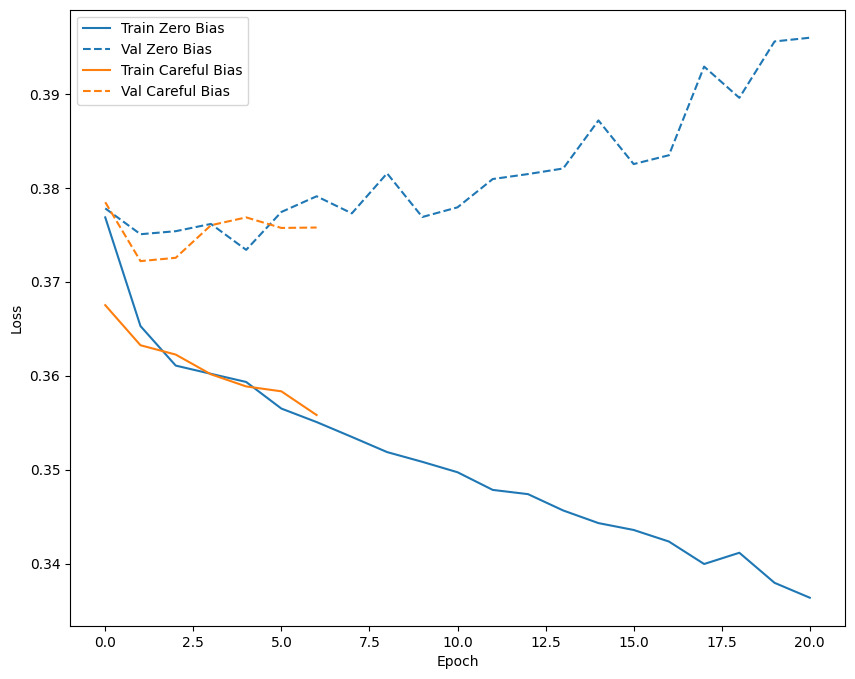

In [ ]:
plot_loss(zero_bias_history,'Zero Bias',0)
plot_loss(careful_bias_history,'Careful Bias',1)

## Train the model

In [ ]:
model = ANN_model()
model.load_weights(initial_weights)
baseline_history = model.fit(x_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[callback],validation_data=(x_val,y_val),verbose=1)


Epoch 1/500
1126/1126 [==============================] - 7s 5ms/step - loss: 0.3689 - tp: 9895.0000 - fp: 1355.0000 - tn: 0.0000e+00 - fn: 3.0000 - accuracy: 0.8793 - precision: 0.8796 - recall: 0.9997 - auc: 0.5172 - prc: 0.8865 - val_loss: 0.3736 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5576 - val_prc: 0.8967
Epoch 2/500
1126/1126 [==============================] - 3s 3ms/step - loss: 0.3638 - tp: 7927.0000 - fp: 1075.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.8806 - precision: 0.8806 - recall: 1.0000 - auc: 0.5561 - prc: 0.9020 - val_loss: 0.3733 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5542 - val_prc: 0.8989
Epoch 3/500
1126/1126 [==============================] - 3s 3ms/step - loss: 0.3621 - tp: 7927.0000 - fp: 1075.0000 - tn: 0.0000

## Check training history

In [ ]:
def plot_metrics(history):
  metrics=['loss','accuracy','precision','recall','prc','auc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
    plt.subplots_adjust(wspace=0.5,hspace=0.5)

    if metric in ['precision','auc','accuracy','prc'] :
      plt.ylim([0.50,plt.ylim()[1]])
    elif metric=='loss':
      plt.ylim([0.3,plt.ylim()[1]])
    else:
      plt.ylim([plt.ylim()[0],plt.ylim()[1]])

  plt.show()

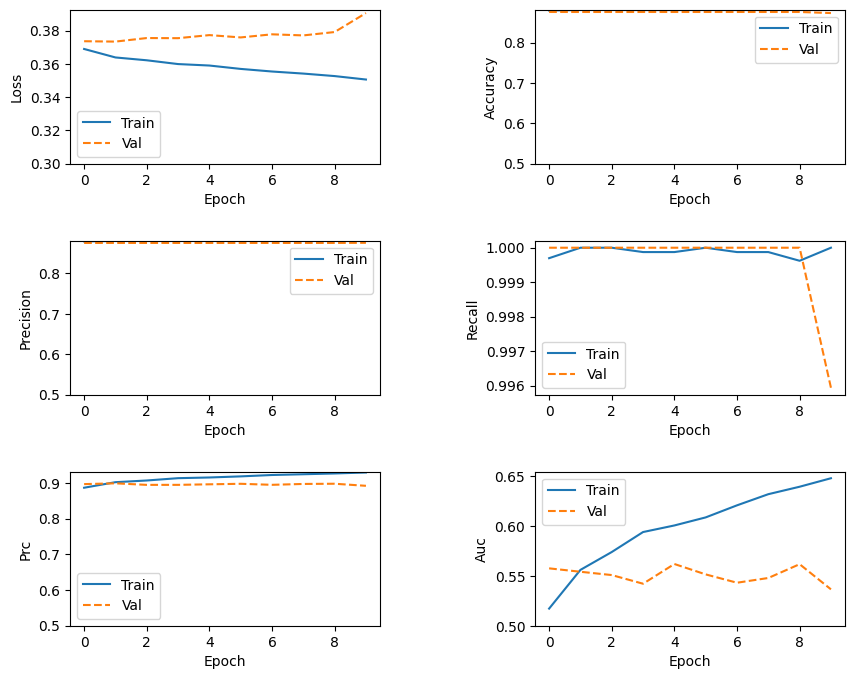

In [ ]:
plot_metrics(baseline_history)

## Evaluate metrics

In [ ]:
train_predictions_baseline = model.predict(x_train,batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(x_test,batch_size=BATCH_SIZE)

352/352 [==============================] - 1s 2ms/step


In [ ]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.3798372149467468
tp :  2465.0
fp :  349.0
tn :  0.0
fn :  0.0
accuracy :  0.8759772777557373
precision :  0.8759772777557373
recall :  1.0
auc :  0.5246930122375488
prc :  0.8874145150184631

Legitimate Transactions Detected (True Negatives):  0
Legitimate Transactions Incorrectly Detected (False Positives):  349
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  2465
Total Fraudulent Transactions:  2465


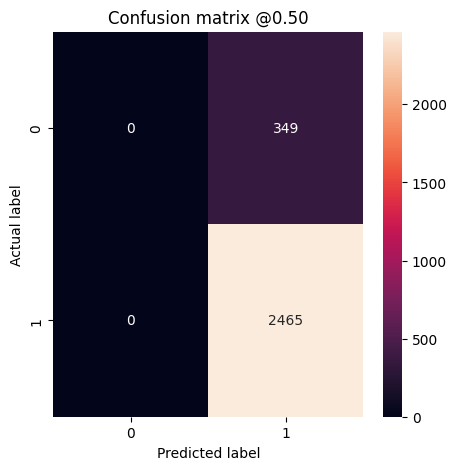

In [ ]:
baseline_results = model.evaluate(x_test,y_test,batch_size=BATCH_SIZE,verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

## Plot the ROC

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim()
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

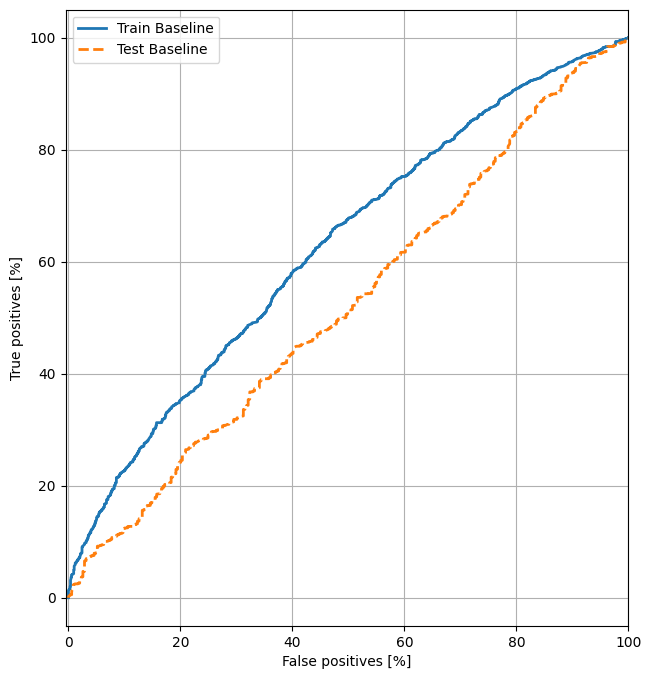

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend()

## Plot the PRC

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlim([-0.05,1.0])
    plt.ylim([-0.05,1.0])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

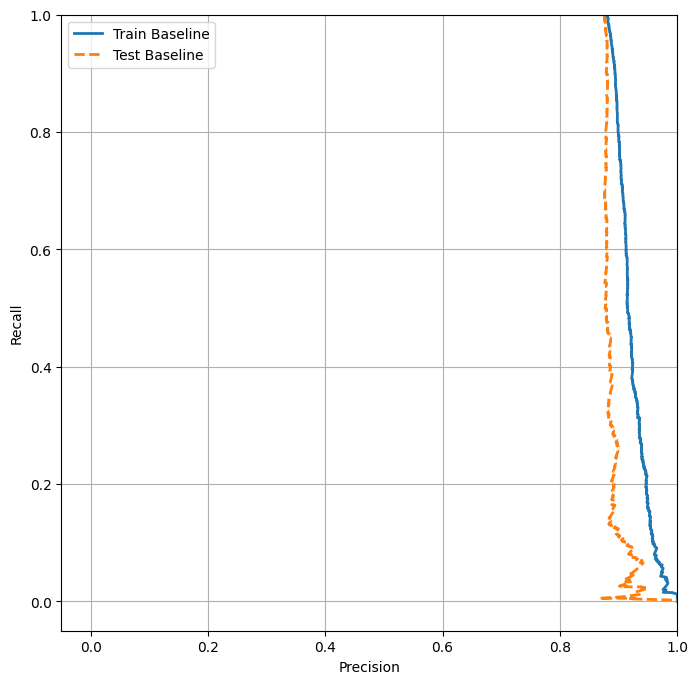

In [ ]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend()

# Class weights

## calculate class weights

In [ ]:
# weight_for_0 = (1/neg)*(total/2.0)
# weight_for_1 = (1/pos)*(total/2.0)
weight_for_0 = 2.0
weight_for_1 = 0.5

class_weight = {0:weight_for_0,1:weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 2.00
Weight for class 1: 0.50


## Train a model with class weights

In [ ]:
weighted_model = ANN_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(x_train,y_train,epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,callbacks=[callback],
                                      validation_data=(x_val,y_val),
                                      class_weight=class_weight,verbose=1)

Epoch 1/500
1126/1126 [==============================] - 6s 4ms/step - loss: 0.4532 - tp: 10024.0000 - fp: 1387.0000 - tn: 37.0000 - fn: 368.0000 - accuracy: 0.8515 - precision: 0.8785 - recall: 0.9646 - auc: 0.5008 - prc: 0.8815 - val_loss: 0.5284 - val_tp: 1926.0000 - val_fp: 272.0000 - val_tn: 8.0000 - val_fn: 45.0000 - val_accuracy: 0.8592 - val_precision: 0.8763 - val_recall: 0.9772 - val_auc: 0.5379 - val_prc: 0.8939
Epoch 2/500
1126/1126 [==============================] - 3s 3ms/step - loss: 0.4382 - tp: 7762.0000 - fp: 1040.0000 - tn: 35.0000 - fn: 165.0000 - accuracy: 0.8661 - precision: 0.8818 - recall: 0.9792 - auc: 0.5556 - prc: 0.9016 - val_loss: 0.4587 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5436 - val_prc: 0.8991
Epoch 3/500
1126/1126 [==============================] - 5s 4ms/step - loss: 0.4347 - tp: 7741.0000 - fp: 1037.0000 - tn: 38.0000 - fn: 186.

## Check training history

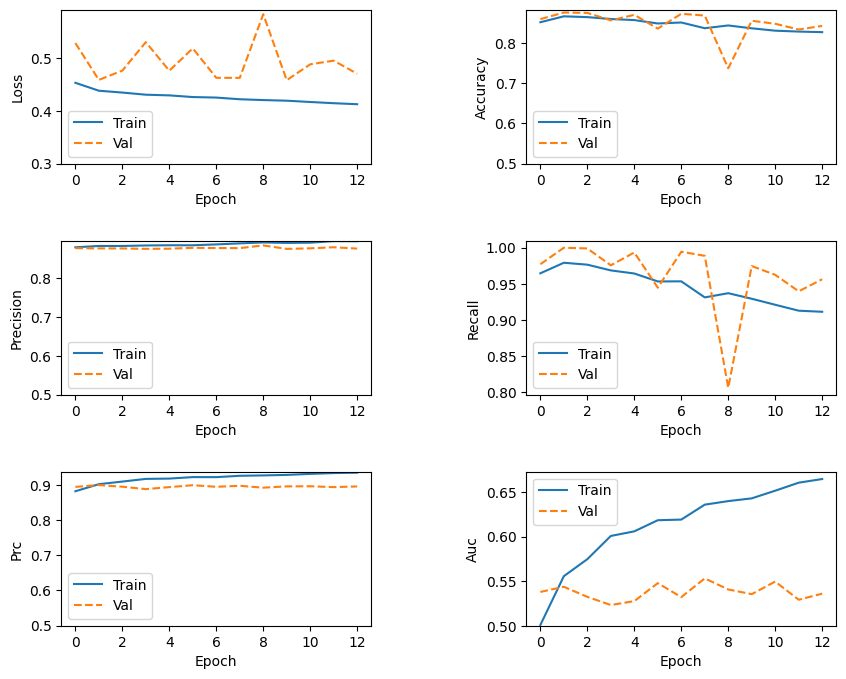

In [ ]:
plot_metrics(weighted_history)

## Evaluate metrics

In [ ]:
train_predictions_weighted = weighted_model.predict(x_train,batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(x_test,batch_size=BATCH_SIZE)

352/352 [==============================] - 0s 1ms/step


loss :  0.4681003987789154
tp :  2425.0
fp :  341.0
tn :  8.0
fn :  40.0
accuracy :  0.8646055459976196
precision :  0.8767172694206238
recall :  0.9837728142738342
auc :  0.5307154655456543
prc :  0.8924912810325623

Legitimate Transactions Detected (True Negatives):  8
Legitimate Transactions Incorrectly Detected (False Positives):  341
Fraudulent Transactions Missed (False Negatives):  40
Fraudulent Transactions Detected (True Positives):  2425
Total Fraudulent Transactions:  2465


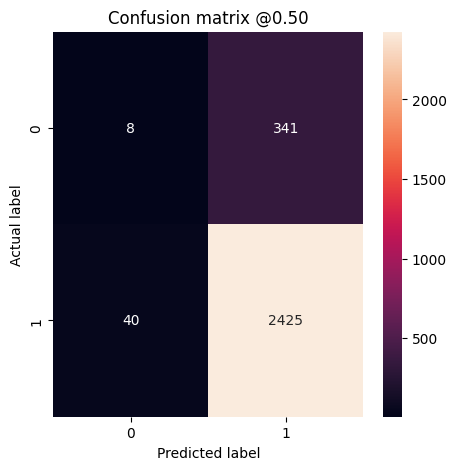

In [ ]:
weighted_results = weighted_model.evaluate(x_test,y_test,batch_size=BATCH_SIZE,verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

## Plot the ROC

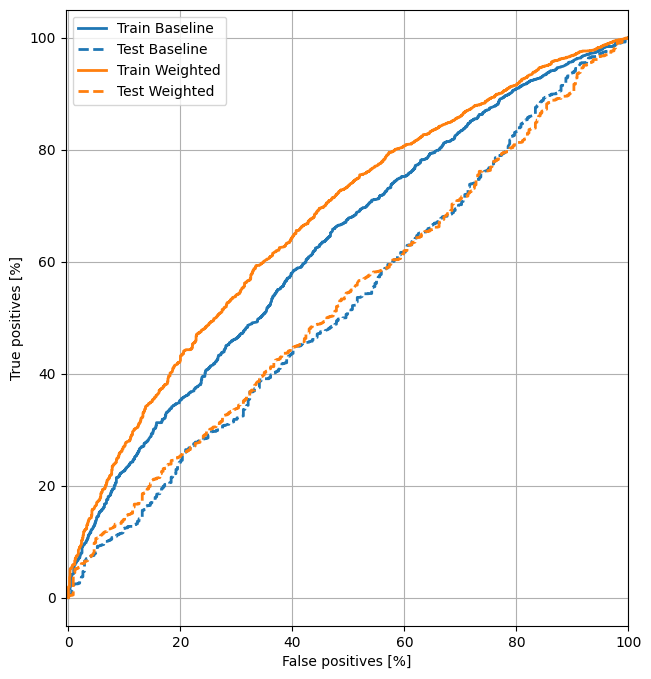

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend()

## Plot the PRC

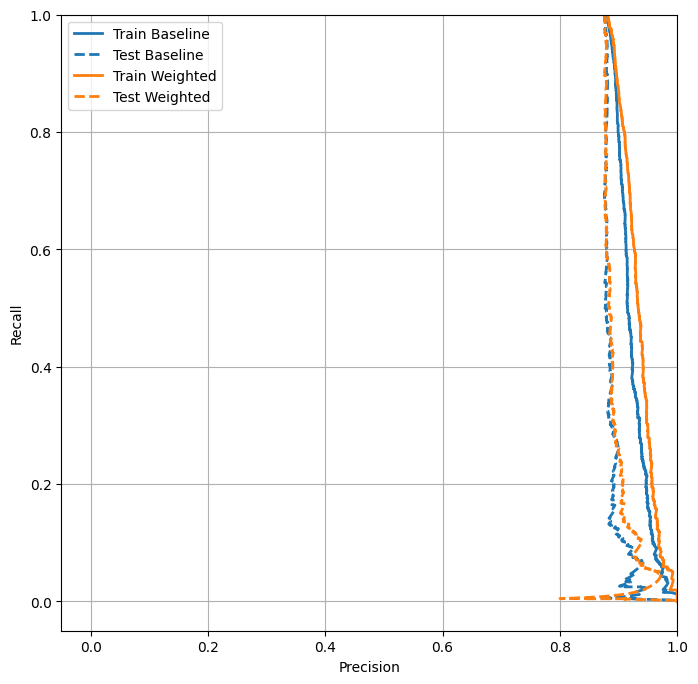

In [ ]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend()

# Oversampling

## oversample the minority class

In [ ]:
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_scaler, y)


In [ ]:
x_resampled = pd.DataFrame(x_resampled,columns=feature_name)

## check the distribution

In [ ]:
y_resampled.value_counts()

survive
1    12363
0    12363
Name: count, dtype: int64

## split the data

In [ ]:
x_train_resampled, x_test_resampled, y_train_resampled, y_test_resampled = train_test_split(x_resampled,y_resampled,test_size=0.2,random_state=42)
x_train_resampled, x_val_resampled, y_train_resampled, y_val_resampled = train_test_split(x_train_resampled,y_train_resampled,test_size=0.2,random_state=42)

## Train on the oversampled data

In [ ]:
resampled_model = ANN_model()
resampled_model.load_weights(initial_weights)
# reset the bias to zero, since the dataset is balanced
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 34)                612       
                                                                 
 dense_25 (Dense)            (None, 34)                1190      
                                                                 
 dense_26 (Dense)            (None, 34)                1190      
                                                                 
 dense_27 (Dense)            (None, 1)                 35        
                                                                 
Total params: 3027 (11.82 KB)
Trainable params: 3027 (11.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
resampled_history = resampled_model.fit(x_train_resampled,y_train_resampled,epochs=EPOCHS,
                              batch_size=BATCH_SIZE,verbose=1,
                              callbacks=[callback],validation_data=(x_val_resampled,y_val_resampled))

Epoch 1/500
1978/1978 [==============================] - 9s 3ms/step - loss: 0.6811 - tp: 6679.0000 - fp: 3668.0000 - tn: 4539.0000 - fn: 3752.0000 - accuracy: 0.6019 - precision: 0.6455 - recall: 0.6403 - auc: 0.6512 - prc: 0.7192 - val_loss: 0.6658 - val_tp: 759.0000 - val_fp: 433.0000 - val_tn: 1555.0000 - val_fn: 1209.0000 - val_accuracy: 0.5849 - val_precision: 0.6367 - val_recall: 0.3857 - val_auc: 0.6300 - val_prc: 0.6372
Epoch 2/500
1978/1978 [==============================] - 6s 3ms/step - loss: 0.6617 - tp: 4311.0000 - fp: 2796.0000 - tn: 5062.0000 - fn: 3655.0000 - accuracy: 0.5923 - precision: 0.6066 - recall: 0.5412 - auc: 0.6318 - prc: 0.6471 - val_loss: 0.6603 - val_tp: 1168.0000 - val_fp: 821.0000 - val_tn: 1167.0000 - val_fn: 800.0000 - val_accuracy: 0.5902 - val_precision: 0.5872 - val_recall: 0.5935 - val_auc: 0.6347 - val_prc: 0.6460
Epoch 3/500
1978/1978 [==============================] - 6s 3ms/step - loss: 0.6470 - tp: 4467.0000 - fp: 2575.0000 - tn: 5283.0000 - 

## check training history

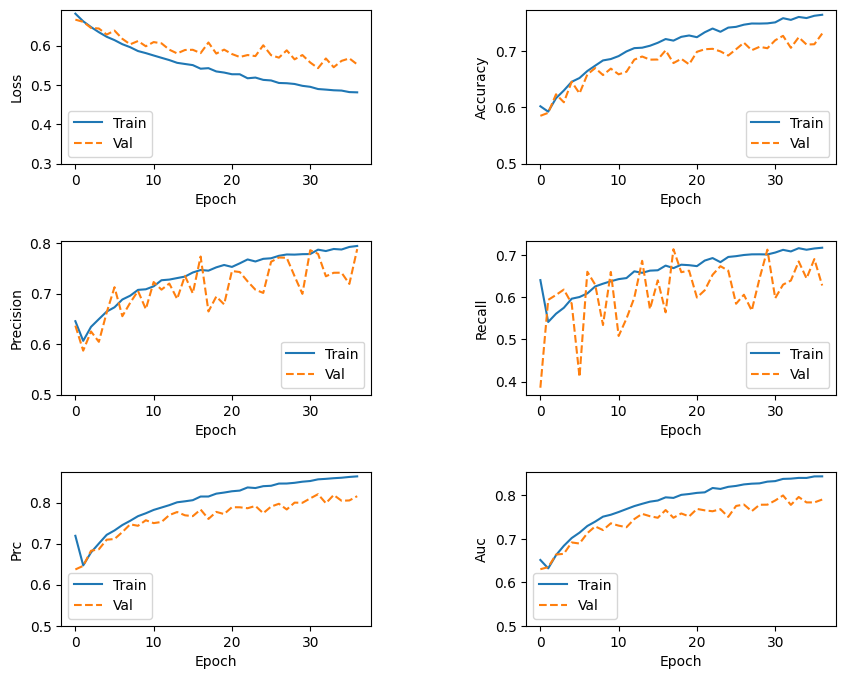

In [ ]:
plot_metrics(resampled_history)


## evaluate metrics

In [ ]:
y_train_pred_resampled = resampled_model.predict(x_train_resampled,batch_size=BATCH_SIZE)
y_test_pred_resampled = resampled_model.predict(x_test_resampled,batch_size=BATCH_SIZE)

619/619 [==============================] - 1s 2ms/step


loss :  0.5449016094207764
tp :  1523.0
fp :  459.0
tn :  2058.0
fn :  906.0
accuracy :  0.7240194082260132
precision :  0.7684157490730286
recall :  0.627007007598877
auc :  0.796731173992157
prc :  0.8169111609458923

Legitimate Transactions Detected (True Negatives):  2058
Legitimate Transactions Incorrectly Detected (False Positives):  459
Fraudulent Transactions Missed (False Negatives):  906
Fraudulent Transactions Detected (True Positives):  1523
Total Fraudulent Transactions:  2429


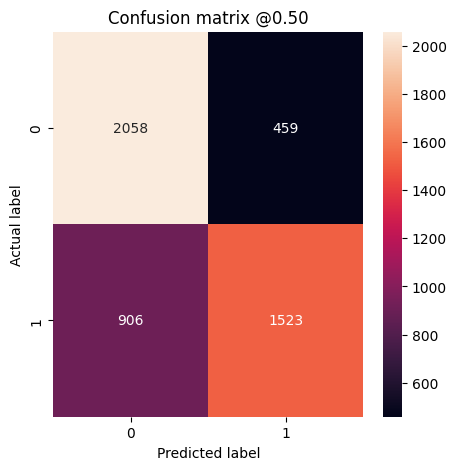

In [ ]:
resampled_results = resampled_model.evaluate(x_test_resampled, y_test_resampled,batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_test_resampled, y_test_pred_resampled)

## plot the ROC

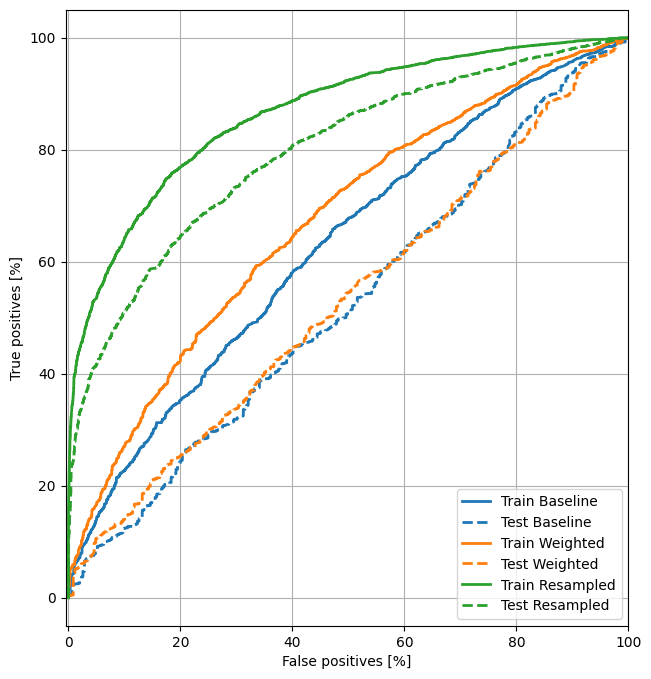

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", y_train_resampled, y_train_pred_resampled, color=colors[2])
plot_roc("Test Resampled", y_test_resampled, y_test_pred_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## plot the AUPRC

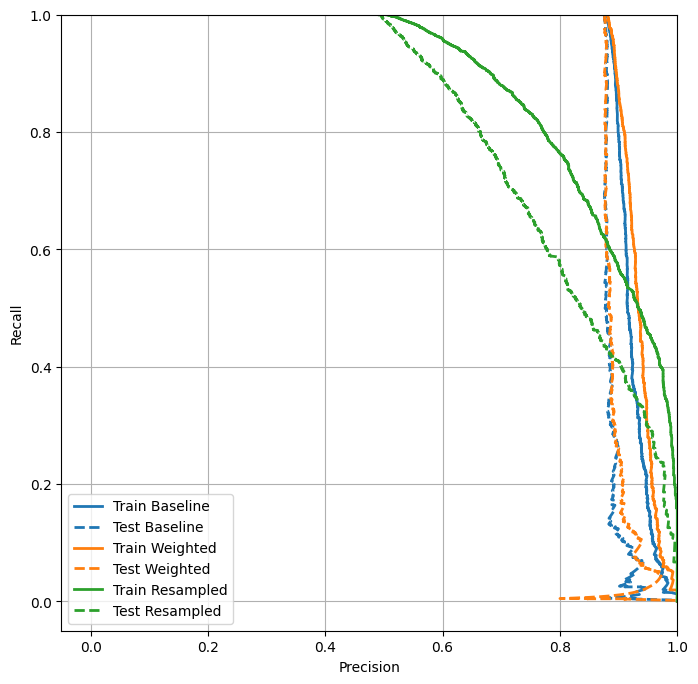

In [ ]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", y_train_resampled, y_train_pred_resampled, color=colors[2])
plot_prc("Test Resampled", y_test_resampled, y_test_pred_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower left')

## feature importance

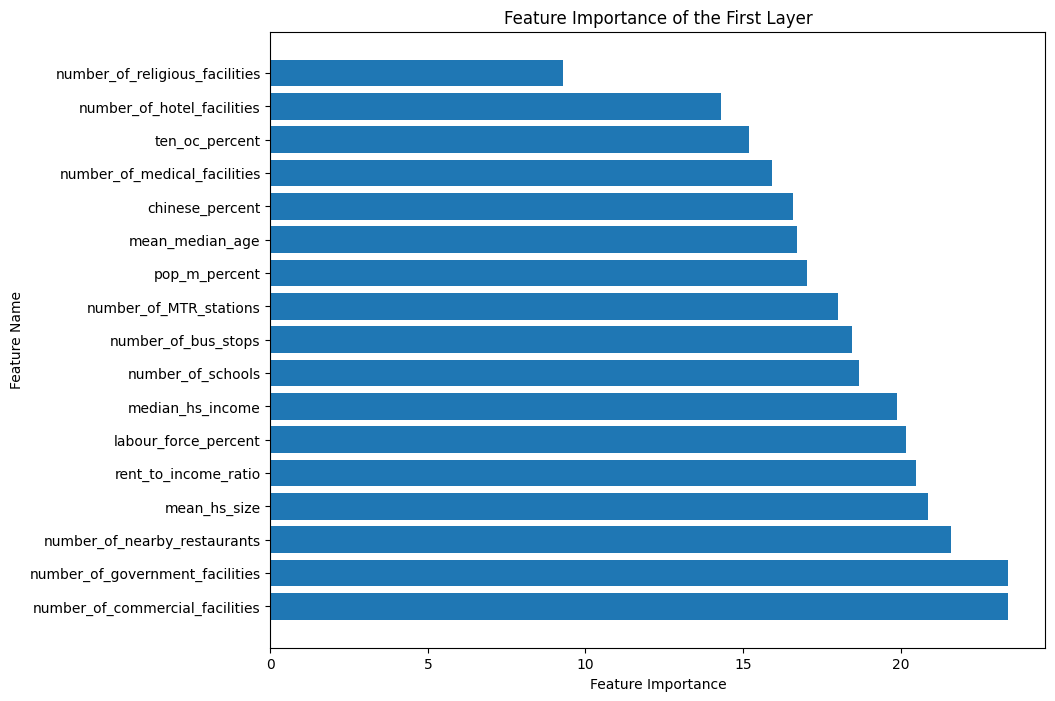

In [ ]:
# get the weights of the first layer
weights = resampled_model.layers[0].get_weights()[0]

# calculate the feature importance
feature_importance = abs(weights).sum(axis=1)

# sort the feature importance in descending order
sorted_indices = feature_importance.argsort()[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_name = feature_name[sorted_indices]

# plot the feature importance(bar plot)
plt.figure(figsize=(10,8))
plt.barh(sorted_feature_name,sorted_feature_importance)
plt.yticks(range(len(sorted_feature_name)),sorted_feature_name)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance of the First Layer')
plt.show()



155/155 [==============================] - 0s 2ms/step


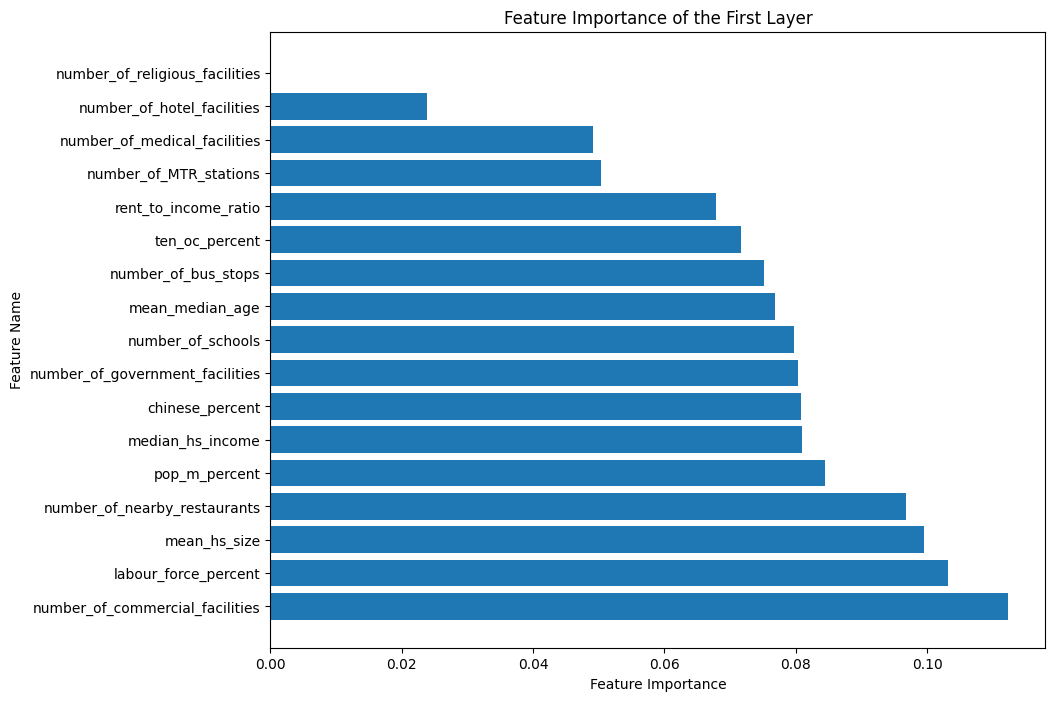

In [ ]:
def score(x,y):
    y_pred = resampled_model.predict(x)
    return accuracy_score(y,y_pred>0.5)

base_score,score_decrease = get_score_importances(score,x_test_resampled.values,y_test_resampled.values,random_state=42)
feature_importance = np.mean(score_decrease,axis=0)

sorted_indices = feature_importance.argsort()[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_name = feature_name[sorted_indices]

plt.figure(figsize=(10,8))
plt.barh(sorted_feature_name,sorted_feature_importance)
plt.yticks(range(len(sorted_feature_name)),sorted_feature_name)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance of the First Layer')
plt.show()


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.6 MB/s eta 0:00:00


In [ ]:
import shap
import tensorflow as tf

# change to numpy format
x_train_values = x_train_resampled.values if isinstance(x_train_resampled, pd.DataFrame) else x_train_resampled
x_test_values = x_test_resampled.values if isinstance(x_test_resampled, pd.DataFrame) else x_test_resampled

# use model to create explainer
explainer = shap.DeepExplainer(resampled_model, x_train_values[:100])

# calculate shap_values
shap_values = explainer.shap_values(x_test_values[:50])

# choose a sample
sample_index = 0
sample_shap_values = shap_values[sample_index,:,0]
sample_features = x_test_values[sample_index]

# assert same shape
assert sample_shap_values.shape[0] == sample_features.shape[0]

# initial
shap.initjs()

# change expected_value
expected_value = explainer.expected_value
if isinstance(expected_value, tf.Tensor):
    expected_value = expected_value.numpy()

if isinstance(expected_value, list):
    expected_value = expected_value[0]

shap.force_plot(expected_value, sample_shap_values, feature_name)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


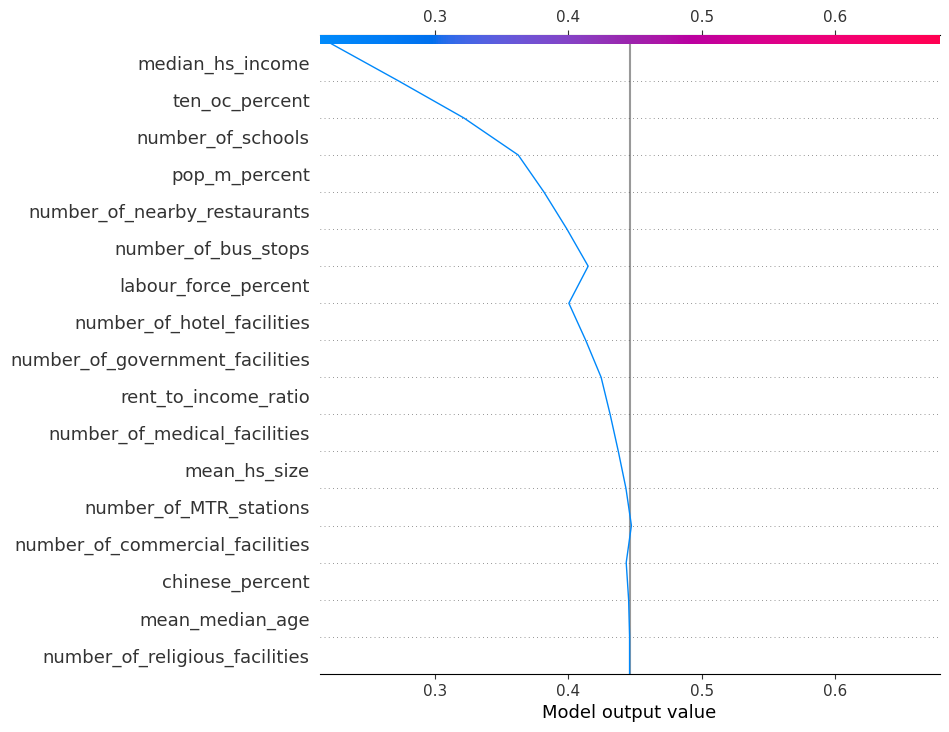

In [ ]:
# create decision_plot
shap.decision_plot(expected_value, sample_shap_values, feature_name)


In [ ]:
# print result of shap_values
for name, value in zip(feature_name, sample_shap_values):
    print(f"{name} = {value:.4f}")

number_of_nearby_restaurants = -0.0172
number_of_bus_stops = -0.0159
number_of_MTR_stations = -0.0041
number_of_schools = -0.0408
number_of_commercial_facilities = 0.0039
number_of_government_facilities = -0.0116
number_of_religious_facilities = 0.0000
number_of_medical_facilities = -0.0062
number_of_hotel_facilities = -0.0127
mean_median_age = -0.0007
median_hs_income = -0.0503
mean_hs_size = -0.0057
labour_force_percent = 0.0145
chinese_percent = -0.0018
pop_m_percent = -0.0193
ten_oc_percent = -0.0491
rent_to_income_ratio = -0.0068


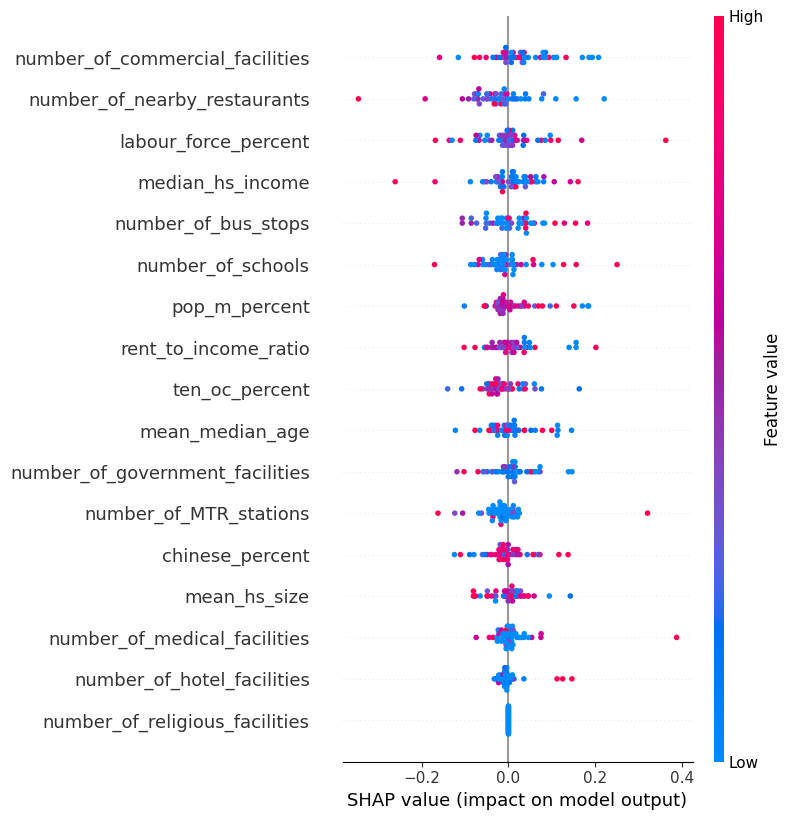

In [ ]:
# create summary_plot
shap.summary_plot(shap_values[:,:,0], x_test_resampled[:50], feature_names=feature_name)

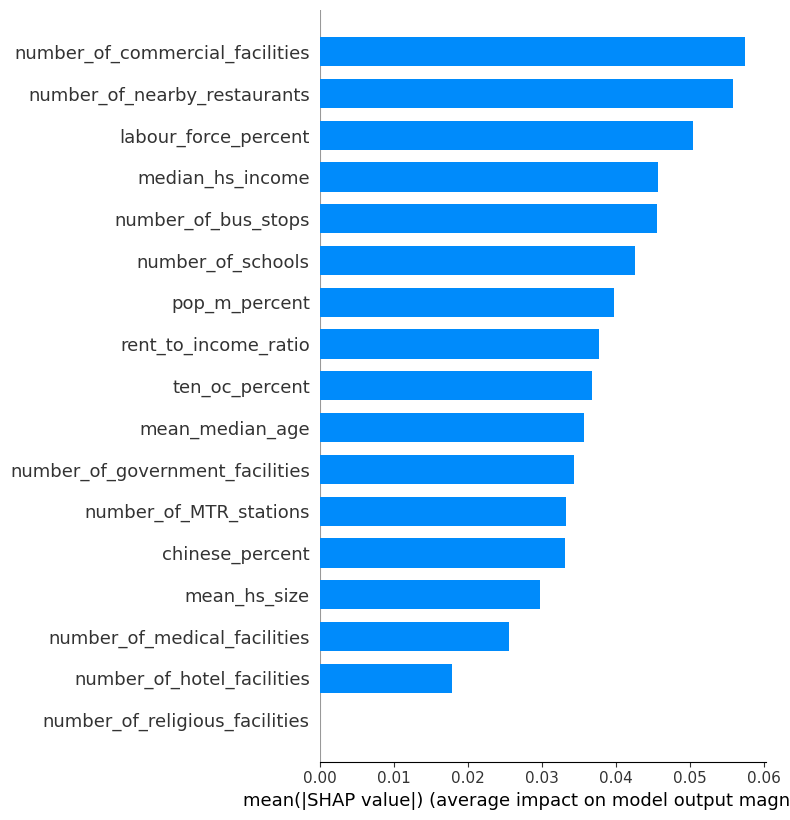

In [ ]:
# create barplot
shap_values_for_output = shap_values[:,:,0]
shap_sum = np.abs(shap_values_for_output).mean(axis=0)
shap.summary_plot(shap_values_for_output, x_test_resampled[:50], plot_type="bar", feature_names=feature_name)

# save model

In [ ]:
# check the existence of the save path
if not os.path.exists(save_path):
  os.makedirs(save_path)
# change the work path to save_path
os.chdir(save_path)
# save the model as json file
model_toJson = resampled_model.to_json()
with open("model.json","w") as json_file:
  json_file.write(model_toJson)
# serialize weights to HDF5
resampled_model.save_weights("model.h5")
# save as pkl file
joblib.dump(resampled_history,'model.pkl')
print('Model saved.')

Model saved.
